In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

import os
from datetime import datetime

In [88]:
# params
latent_dim = 64
model_type = "conv"

log_dir = os.getcwd() + "/logs/train" + str(datetime.now())
print(log_dir)

/Users/kyleziegler/Desktop/repos/anomaly-detection-tf/logs/train2022-06-26 11:08:06.694919


In [46]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-06-26 10:44:03.157083: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 10:44:03.157105: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [47]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [87]:
class Autoencoder(Model):
  def __init__(self, latent_dim, model_type):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim

    if model_type == "conv":
      self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(16, (3,3), activation='relu', input_shape=x_train.shape[1:]),
        layers.Flatten(),
      ])
      self.decoder = tf.keras.Sequential([
        layers.Dense(784, activation='sigmoid'),
        layers.Reshape((28, 28))
      ])
    elif model_type == "dense":
      self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
      ])
      self.decoder = tf.keras.Sequential([
        layers.Dense(784, activation='sigmoid'),
        layers.Reshape((28, 28))
      ])
    else:
      raise ValueError("Unsupported model type")

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim, model_type)



ValueError: Input 0 of layer "conv_lstm2d" is incompatible with the layer: expected ndim=5, found ndim=4. Full shape received: (None, 28, 28, 1)

In [85]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [86]:


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir,
                                                      histogram_freq=1,
                                                      profile_batch='0,100',
                                                    )

autoencoder.fit(x_train, x_train,
                batch_size=100,
                epochs=2,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback])

Epoch 1/2
  5/600 [..............................] - ETA: 8s - loss: 0.1191  

2022-06-26 10:59:13.326635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


598/600 [============================>.] - ETA: 0s - loss: 0.0116

2022-06-26 10:59:21.120917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [73]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

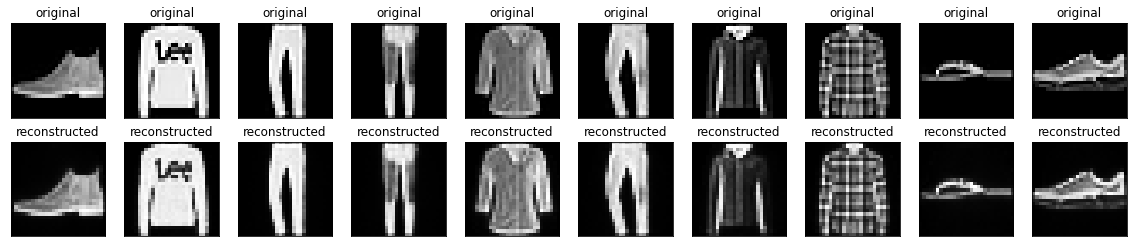

In [74]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [75]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [76]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 60271), started 23:02:16 ago. (Use '!kill 60271' to kill it.)